####Copyright https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans

In [ ]:
#Import some usefull libraries
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
#Hyperparameters
batch_size = 32
learning_rate = 5e-7

In [ ]:
#other constants
DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
DATA_FILENAME = "BostonHousing.csv"
TARGET_COLUMN = 'medv'
input_size = 13
output_size = 1

#Dataset and Data loaders

In [ ]:
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

Using downloaded and verified file: ./BostonHousing.csv


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:

#Convert from pandas dataframe to numpy array
inputs = dataframe.drop('medv', axis=1).values
targets = dataframe[['medv']].values
inputs.shape, targets.shape

((506, 13), (506, 1))

In [ ]:
#Conver to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, valid_ds = random_split(dataset, [406, 100])

#Converting into image batches using DataLoader library
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size * 2)

In [ ]:


train_ds

#Define the Model

In [ ]:

class HousingModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, output_size)

  def forward(self, xb):
    out = self.linear(xb)
    return out

  def training_step(self, batch):
    inputs, targets = batch
    out = self(inputs)
    loss = F.mse_loss(out, targets)
    return loss

  def validation_step(self, batch):
    inputs, targets = batch
    out = self(inputs)
    loss  = F.mse_loss(out, targets)
    return {'val_loss': loss.detach()}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    return {'val_loss': epoch_loss.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
model = HousingModel()

#Training function

In [ ]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, valid_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #VAlidation phase
    if epoch % 100 == 0:
      result = evaluate(model, val_loader)
      model.epoch_end(epoch, result)
      history.append(result)
  return history

In [ ]:

result = evaluate(model, val_loader)

In [ ]:

result

{'val_loss': 66.76911926269531}

In [ ]:
history = fit(600, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 64.5961
Epoch [100], val_loss: 62.7380
Epoch [200], val_loss: 61.8080
Epoch [300], val_loss: 61.4838
Epoch [400], val_loss: 60.5150
Epoch [500], val_loss: 61.0036


Text(0.5, 1.0, 'val_loss vs. epochs')

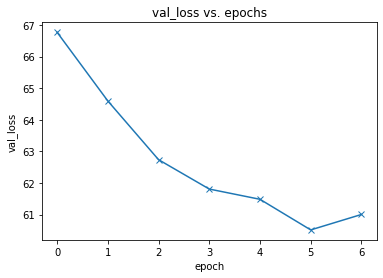

In [ ]:
#Plot the losses
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs')


In [ ]:
#Predicting the model on test data set
def predict_single(x, model):
  xb = x.unsqueeze(0)
  return model(x).item()

x, target = valid_ds[0]
pred = predict_single(x, model)

In [ ]:
print('input:', x)
print('target:', target.item())
print('prediction:', pred)

input: tensor([1.1504e-01, 0.0000e+00, 2.8900e+00, 0.0000e+00, 4.4500e-01, 6.1630e+00,
        6.9600e+01, 3.4952e+00, 2.0000e+00, 2.7600e+02, 1.8000e+01, 3.9183e+02,
        1.1340e+01])
target: 21.399999618530273
prediction: 23.85258674621582


#Saving the model

In [ ]:
torch.save(model.state_dict(), 'housing-linear-pth')

In [ ]:
model2 = HousingModel()
model2.load_state_dict(torch.load('housing-linear-pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0546,  0.1359, -0.0247, -0.0568, -0.1596,  0.0782,  0.0933,  0.0010,
                       -0.0774,  0.0051,  0.0657,  0.0489, -0.4116]])),
             ('linear.bias', tensor([0.0902]))])

In [ ]:
x, target = valid_ds[10]
pred = predict_single(x, model2)

In [ ]:
print('pred:', pred)
print('target:', target)

pred: 24.48811912536621
target: tensor([25.])
